<center><h1>DSCI-552 HOMEWORK 4-Part1</h1><center>
<br>
<center><font size="4"></font></center>
<center><font size="3"><strong>Mason(Mohan) Xing</font></center>
<center><font size="3"><strong>USCID:	6880083372</font></center>

In [1]:
# import dependencies
import warnings
warnings.filterwarnings("ignore")

import os
import urllib
import pandas as pd
import numpy as np
from impyute.imputation.cs import mice, fast_knn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt, floor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# check the environment
print (os.environ['CONDA_DEFAULT_ENV'])

dsci552


# 1. The LASSO and Boosting for Regression
## 1(a)  Download the Communities and Crime data1 from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as the training set and the rest as the test set.

In [2]:
datafile = "../data/communities.data"
namefile = "../data/communities.names"

Note: do not need to run this code below, datafiles have been downloaded

In [3]:
# # download original dataset 
# url_data = "https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data"
# url_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.names"

# urllib.request.urlretrieve(url_data, datafile)
# urllib.request.urlretrieve(url_name, namefile)

In [4]:
# read communities.names file and obtain column names
attributes = []
with open(namefile, 'r') as f:
    lines = f.readlines()
    for line in lines:
        if (line.startswith('@attribute')):
            attributes.append(line.split(" ")[1])

In [5]:
# define a function to split train and test data
def tr_ts_split(data):
    
    tr = data.iloc[0:1495]
    ts = data.iloc[1495::]
    
    return tr, ts

In [6]:
# reading communities.data file assign column and assign na_values
data_original =  pd.read_csv(datafile, sep="," , header=None, names=attributes, na_values= '?')
# define train and test data
train_data_original, test_data_original = tr_ts_split(data_original)
print("Training data shape: ",train_data_original.shape)
print("Test data shape: ",test_data_original.shape)

Training data shape:  (1495, 128)
Test data shape:  (499, 128)


## 1(b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.
ref: https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py

In [7]:
print("Not predictive attributes: ",attributes[:5])
# select predictive data by ignore the nonpredictive features
data = data_original.iloc[:, 5:] # ignore nonpredictive features
train_data, test_data = tr_ts_split(data)

Not predictive attributes:  ['state', 'county', 'community', 'communityname', 'fold']


In [8]:
# missing_ratio 
missing_ratio = data.apply(lambda x : sum(x.isna()) / len(x), axis=0)
print(missing_ratio.loc[missing_ratio != 0])

OtherPerCap             0.000502
LemasSwornFT            0.840020
LemasSwFTPerPop         0.840020
LemasSwFTFieldOps       0.840020
LemasSwFTFieldPerPop    0.840020
LemasTotalReq           0.840020
LemasTotReqPerPop       0.840020
PolicReqPerOffic        0.840020
PolicPerPop             0.840020
RacialMatchCommPol      0.840020
PctPolicWhite           0.840020
PctPolicBlack           0.840020
PctPolicHisp            0.840020
PctPolicAsian           0.840020
PctPolicMinor           0.840020
OfficAssgnDrugUnits     0.840020
NumKindsDrugsSeiz       0.840020
PolicAveOTWorked        0.840020
PolicCars               0.840020
PolicOperBudg           0.840020
LemasPctPolicOnPatr     0.840020
LemasGangUnitDeploy     0.840020
PolicBudgPerPop         0.840020
dtype: float64


Seems like these columns are missing 84% data, which is a more than 30%, probably using mean or median numbers to perform data imputation is not a good choice, but I am not sure right now.Then I will try to perform data imputation using different methods to see which one is better

In [9]:
def xy_split(dataset):
    
    X = dataset.iloc[:, :-1]
    y = dataset.iloc[:, -1]
    
    return X, y

In [10]:
# Perform data imputation test on training set to say which one is better
X, y = xy_split(train_data)

model = LinearRegression()
results = []
cv = KFold(n_splits=5, shuffle=True, random_state= 42)
# cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state= 42)
strategies = ['mean', 'median', 'most_frequent', 'constant']
for s in strategies:
    pipeline = Pipeline([('impute', SimpleImputer(missing_values=np.nan,strategy=s)),('model', model)])
    scores = cross_val_score(pipeline, X.values, y.values, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    results.append(-scores)

pipeline2 = Pipeline([('impute', IterativeImputer(random_state=42, missing_values=np.nan)),('model', BayesianRidge())])
score2 = cross_val_score(pipeline, X.values, y.values, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

for method, score in zip(strategies, results):
    print('Method: SimpleImputer-{0}, mean score: = {1:.4f}, min MSE: {2:.4f}'.format(method, np.mean(score), np.min(score)))
    
print('Method: {0}, mean score: = {1:.4f}, min MSE: {2:.4f}'.format('IterativeImputer', np.mean(-score2), np.min(-score2)))

Method: SimpleImputer-mean, mean score: = 0.0208, min MSE: 0.0172
Method: SimpleImputer-median, mean score: = 0.0208, min MSE: 0.0173
Method: SimpleImputer-most_frequent, mean score: = 0.0208, min MSE: 0.0172
Method: SimpleImputer-constant, mean score: = 0.0206, min MSE: 0.0172
Method: IterativeImputer, mean score: = 0.0206, min MSE: 0.0172


Based on the result, seems like SimpleImputer-constant, and IterativeImputer performs really good. However the test error during crossvalidation, does not make a huge difference. Since 84% of data are missing in some features, I prefer to use 'most frequent' imputation method in the below questions

In [11]:
# Imputation Using scikit-learn SimpleImputer :
def impute_simple(tr, ts, strategy):
    '''
    strategies = ['mean', 'median', 'most_frequent', 'constant']

    '''
    X_tr, y_tr = xy_split(tr)
    X_ts, y_ts = xy_split(ts)
    
    imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imp.fit(X_tr.values)
    imputed_X_tr = pd.DataFrame(imp.transform(X_tr.values), columns=X_tr.columns, index=y_tr.index)
    imputed_X_ts = pd.DataFrame(imp.transform(X_ts.values), columns=X_ts.columns, index=y_ts.index)
    
    imputed_tr = pd.concat([imputed_X_tr, y_tr], axis=1)
    imputed_ts = pd.concat([imputed_X_ts, y_ts], axis=1)
    
    return imputed_tr, imputed_ts

In [12]:
# Imputation Using scikit-learn IterativeImputer :
def impute_iterative(tr, ts, estimator):
    '''estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
    ]
    '''
    
    X_tr, y_tr = xy_split(tr)
    X_ts, y_ts = xy_split(ts)
    
    imp = IterativeImputer(estimator=estimator, random_state=42, missing_values=np.nan, max_iter=100)
    imp.fit(X_tr.values)
    imputed_X_tr = pd.DataFrame(imp.transform(X_tr.values), columns=X_tr.columns, index=y_tr.index)
    imputed_X_ts = pd.DataFrame(imp.transform(X_ts.values), columns=X_ts.columns, index=y_ts.index)
    
    imputed_tr = pd.concat([imputed_X_tr, y_tr], axis=1)
    imputed_ts = pd.concat([imputed_X_ts, y_ts], axis=1)
    
    return imputed_tr, imputed_ts

In [13]:
# Imputation Using Multivariate Imputation by Chained Equation (MICE) (This takes more than two hours)
def impute_mice(tr, ts):
    imputed_tr = pd.DataFrame(mice(tr.values), columns=tr.columns)
    imputed_ts = pd.DataFrame(mice(ts.values), columns=ts.columns)

    return imputed_tr, imputed_ts

In [14]:
%%time
# perform data imputation 
imputed_train, imputed_test = impute_simple(train_data, test_data, 'most_frequent')
imputed_data = imputed_train.append(imputed_test, ignore_index=True)
print("Number of Missing Data: ", imputed_data.isna().sum().sum())
imputed_data.head()

Number of Missing Data:  0
Wall time: 18 ms


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.04,0.02,0.74,0.0,0.00,0.10,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.04,0.02,0.74,0.0,0.00,0.10,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.04,0.02,0.74,0.0,0.00,0.10,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.04,0.02,0.74,0.0,0.00,0.10,0.03


## 1(c) Plot a correlation matrix for the features in the data set.

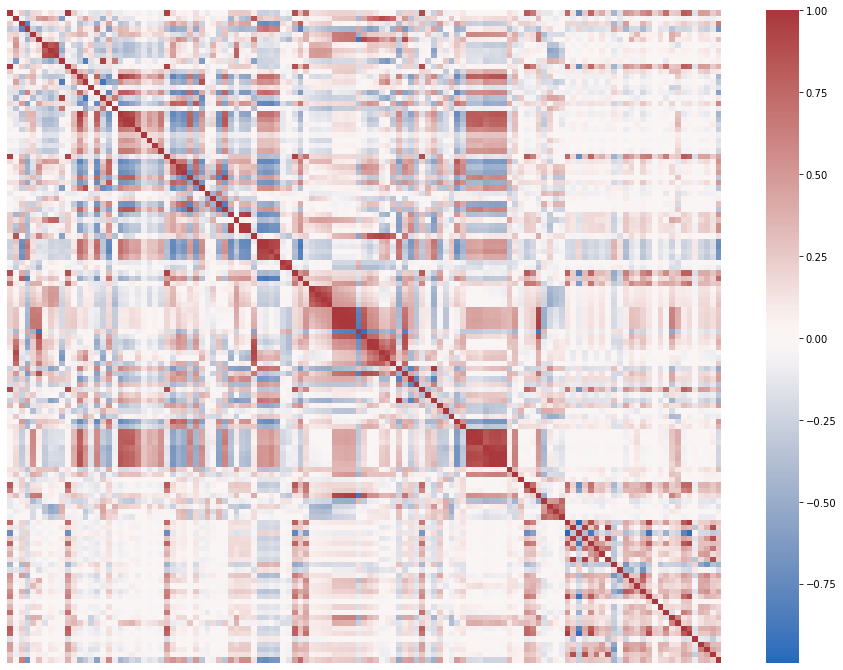

In [15]:
# Compute the correlation matrix
corrMatrix=imputed_data.corr()
plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(corrMatrix, cmap='vlag',  xticklabels=False, yticklabels=False)

## 1(d) Calculate the Coefficient of Variation CV for each feature, where CV = s/m, in which s is sample standard deviation and m is sample mean..

In [16]:
#define function to calculate cv
CV = lambda x: np.std(x, ddof=1) / np.mean(x)
#calculate CV for each column in data frame
COV = imputed_data.apply(CV)
print(COV)

population             2.203503
householdsize          0.353298
racepctblack           1.410920
racePctWhite           0.323782
racePctAsian           1.359162
                         ...   
LemasPctPolicOnPatr    0.118354
LemasGangUnitDeploy    3.247445
LemasPctOfficDrugUn    2.555266
PolicBudgPerPop        0.646312
ViolentCrimesPerPop    0.979015
Length: 123, dtype: float64


## 1(e) Pick $\left \lfloor \sqrt{128} \right \rfloor$ features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

In [17]:
# Highest CV calculation
num_features = floor(sqrt(128))
highest_cv = COV.sort_values(ascending=False)[:num_features]
print(highest_cv)

PctPolicAsian          5.447835
NumStreet              4.407702
PctPolicHisp           4.295042
PctPolicBlack          3.523261
NumInShelters          3.485481
LemasGangUnitDeploy    3.247445
NumIlleg               2.994196
NumImmig               2.900497
LemasPctOfficDrugUn    2.555266
NumUnderPov            2.304970
population             2.203503
dtype: float64


In [18]:
# Here we choose the features based on CV, and we add our predict feature column as 'Hue', when do pair plot
highest_features = list(highest_cv.index)
select_features = highest_features.copy()
select_features.append("ViolentCrimesPerPop")
df_select = imputed_data[select_features]
# binned "ViolentCrimesPerPop" column
bins = [0, 0.5, 1.0]
labels = ['0-0.5','0.5-1']
binned = pd.cut(df_select['ViolentCrimesPerPop'], bins=bins, labels=labels)
df_e = df_select.copy()
df_e['ViolentCrimesPerPop_binned'] = binned
df_e = df_e.drop(['ViolentCrimesPerPop'], axis=1)

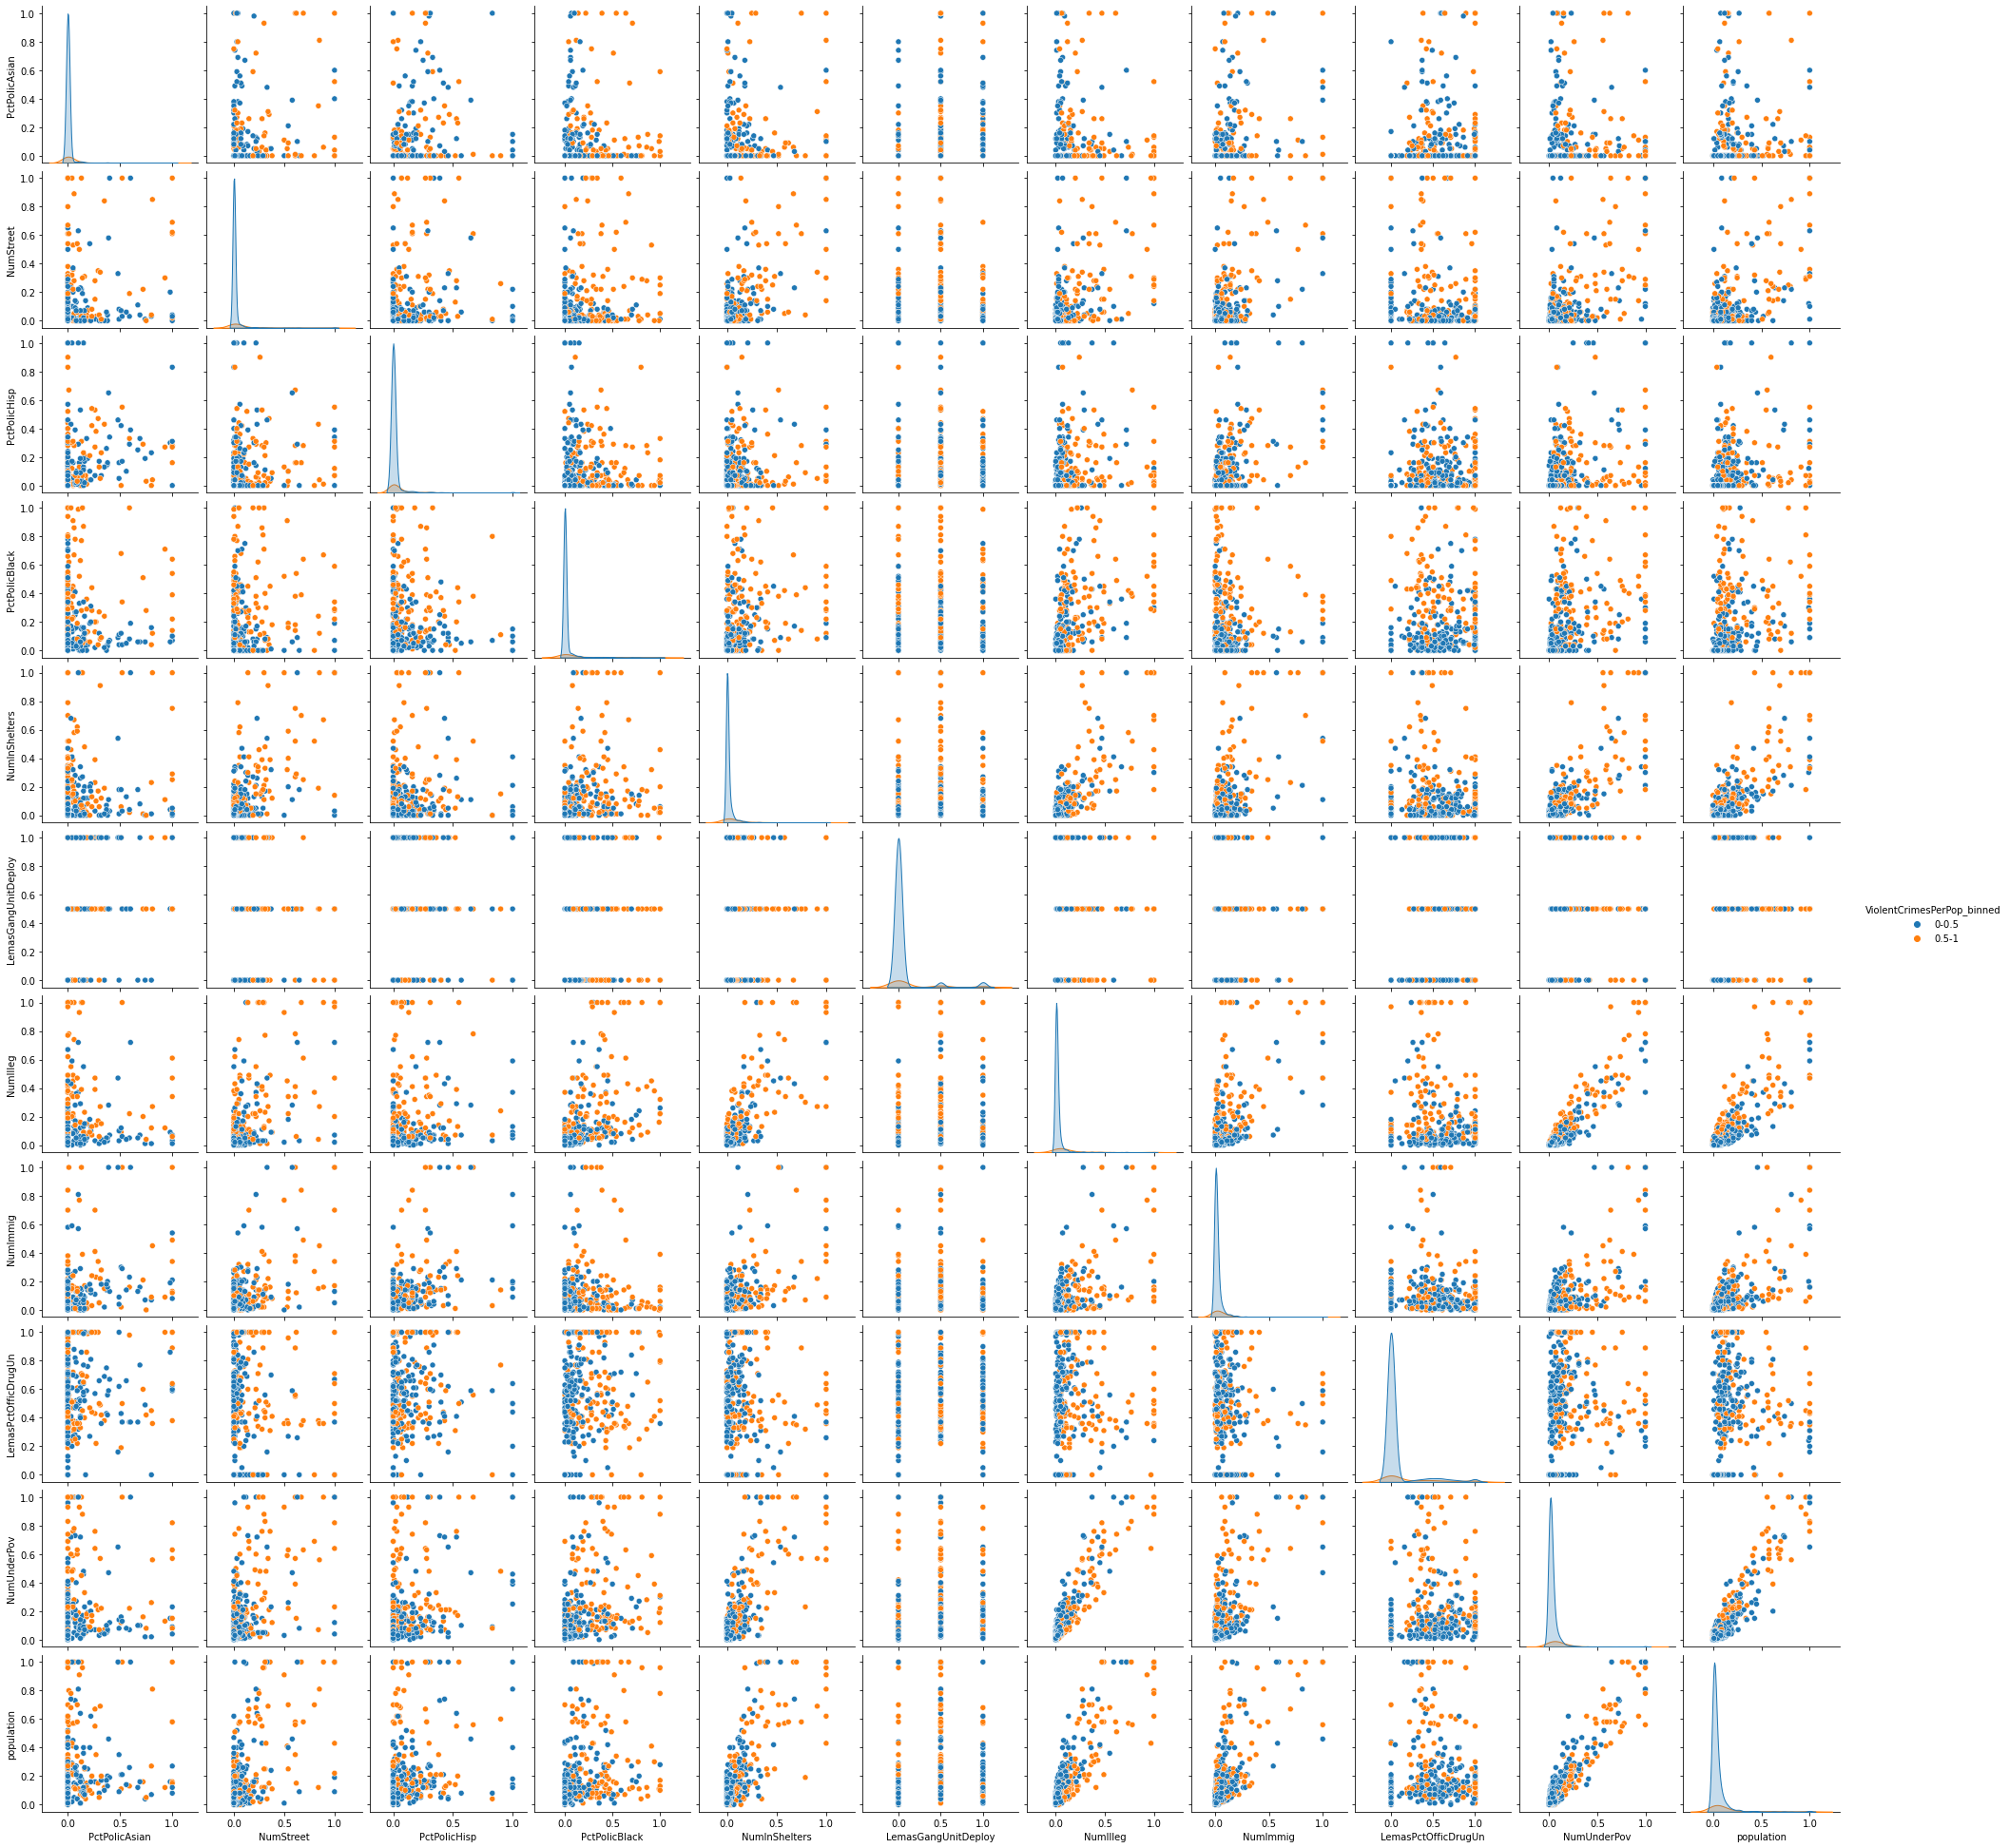

In [19]:
sns.pairplot(df_e, hue = 'ViolentCrimesPerPop_binned')
plt.show()

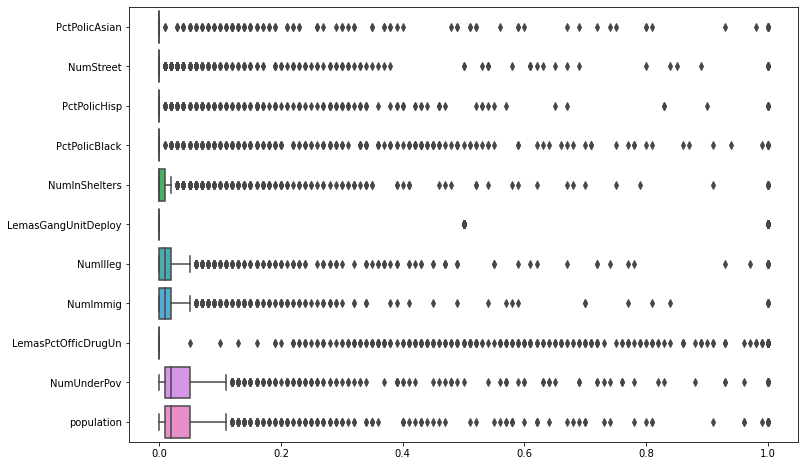

In [20]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df_e, orient="h")
plt.show()

<strong>Answer</strong><br>
* Based on the pair plot we see (NumUnderPov, population),(NumUnderPov,NumIlleg) have some stronge correlation. (NumIlleg, population), (NumImmig, population) have stronge correlation when ViolentCrimesPerPop is low.
* When the 'ViolentCrimesPerPop' is low (<0.5), NumStreet, NumInShelters, NumIlleg, NumImmig, NumUnderPov are also very low.
* Some models prefer features do not have correlation with each other for example Lasso, so that LemasGangUnitDeploy, NumStreet, PctPolicHisp, PctPolicBlack, NumInShelters can be good features

## 1(f) Fit a linear model using least squares to the training set and report the test error. 

In [21]:
# preprocess data to obtain X_train, X_test, y_train, y_test
def dataPreprocess(tr, ts):
    
    X_train, y_train = xy_split(tr)
    X_test, y_test = xy_split(ts)
    
    return X_train, X_test, y_train, y_test

In [22]:
# define trainX, testX, ytrain, ytest
X_train, X_test, y_train, y_test = dataPreprocess(imputed_train, imputed_test)
# define a list to store test error results
error_list = []

In [23]:
# create the model
lm = LinearRegression(n_jobs=-1)
# Fit the model to the training data and calculate the MSE for the training and testing data
lm.fit(X_train, y_train)
y_test_pred = lm.predict(X_test)
# calculate test error
test_error_1f = mean_squared_error(y_test, y_test_pred)
error_list.append(test_error_1f)
print("Test Error is: ", test_error_1f)

Test Error is:  0.01800281411955991


## 1(g) Fit a ridge regression model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained.

In [24]:
# create the model
N_SPLITS = 5
alphas=[10 ** i for i in range(-6, 6)]
cv = KFold(n_splits=N_SPLITS, shuffle = True, random_state= 42)
rig_reg = RidgeCV(alphas=alphas, cv=cv) 
# Fit the model to the training data and calculate the scores for the training and testing data
rig_reg.fit(X_train, y_train) 
y_test_pred = rig_reg.predict(X_test) #RidgeCV will return the best lambda model
# calculate test error
test_error_1g = mean_squared_error(y_test, y_test_pred)
best_alpha_1g = rig_reg.alpha_
error_list.append(test_error_1g)
print("best_alpha(lambada): ", best_alpha_1g)
print("Ridge Regression Model Test Error is: ", test_error_1g)

best_alpha(lambada):  10.0
Ridge Regression Model Test Error is:  0.017320581633624127


<strong>Answer</strong><br>
The performance of rigde regression model is much better than linear model

## 1(h) Fit a LASSO model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model.Repeat with standardized features. Report the test error for both cases and compare them.

- Normalized (original) Features

In [25]:
# create the model
n_alphas = 1000
max_iter = 2000
lasso = LassoCV(n_alphas= n_alphas, cv=cv, n_jobs=-1)
# Fit the model to the training data and calculate the scores for the training and testing data
lasso.fit(X_train, y_train)
y_test_pred = lasso.predict(X_test)
test_error_1h = mean_squared_error(y_test, y_test_pred)
best_alpha_1h = lasso.alpha_

temp_alpha_list = []
temp_error_list = []
temp_alpha_list.append(best_alpha_1h)
temp_error_list.append(test_error_1h)

error_list.append(test_error_1h)
print("best_alpha(lambada): ", best_alpha_1h)
print("Lasso Model Test Error is: ", test_error_1h)

best_alpha(lambada):  0.0001158555595564521
Lasso Model Test Error is:  0.017577899830118388


In [26]:
# report the variables selected by the model
temp_dict = {}
temp_dict['variables'] = X_train.columns
temp_dict['coefficient'] = lasso.coef_
df_temp = pd.DataFrame.from_dict(temp_dict)
df_h = df_temp.loc[df_temp.coefficient!=0]
df_h.sort_values(by=['coefficient'], ascending=False)

,variables,coefficient
2,racepctblack,0.269684
68,PctPersDenseHous,0.217950
90,NumStreet,0.162730
85,MedRent,0.162509
33,PctEmploy,0.135371
...,...,...
48,PctWorkMom,-0.128780
28,PctPopUnderPov,-0.143528
82,RentLowQ,-0.157414
44,PctKids2Par,-0.195063


- Standarized Features

In [27]:
# Standarized features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)
# create the model
lasso_std = LassoCV(n_alphas= n_alphas, cv=cv, n_jobs=-1)
# Fit the model to the training data and calculate the scores for the training and testing data
lasso_std.fit(X_train_std, y_train)
y_test_pred = lasso_std.predict(X_test_std)

test_error_1h_std = mean_squared_error(y_test, y_test_pred)
best_alpha_1h_std = lasso_std.alpha_

temp_alpha_list.append(best_alpha_1h_std)
temp_error_list.append(test_error_1h_std)
error_list.append(test_error_1h_std)

print("best_alpha(lambada): ", best_alpha_1h_std)
print("Lasso Model Standarized Data Test Error is: ", test_error_1h_std)

best_alpha(lambada):  0.0005994319596582459
Lasso Model Standarized Data Test Error is:  0.017854276539796335


In [28]:
temp_dict = {}
temp_dict['variables'] = X_train.columns
temp_dict['coefficient'] = lasso_std.coef_
df_temp = pd.DataFrame.from_dict(temp_dict)
df_h_std = df_temp.loc[df_temp.coefficient!=0]
df_h_std.sort_values(by=['coefficient'], ascending=False)

,variables,coefficient
2,racepctblack,0.068888
68,PctPersDenseHous,0.043996
85,MedRent,0.031807
39,MalePctNevMarr,0.025767
33,PctEmploy,0.025480
...,...,...
48,PctWorkMom,-0.022667
28,PctPopUnderPov,-0.030890
82,RentLowQ,-0.031329
44,PctKids2Par,-0.039758


In [29]:
# result comparision
temp_dict = {}
temp_dict['best_alpha'] = temp_alpha_list
temp_dict['test_error'] = temp_error_list
df_g_summary = pd.DataFrame.from_dict(temp_dict)
df_g_summary.index=['Normalized','Standardized']
df_g_summary

,best_alpha,test_error
Normalized,0.000116,0.017578
Standardized,0.000599,0.017854


<strong>Answer</strong><br>
* The standarized data based on normalized data has a slightly higher test error than normalized data. 
* Since the test error is only increaed by 0.00028, we can say these two methods does not make too much difference.
* The results are pretty much the same, since the data has already normalized.
* Standarized data based on normalized data does not make the prediction error better

## 1(i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.
ref https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html

In [30]:
# Define a pipeline to search for the best combination of PCA truncation and classifier regularization.
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('classifier', LinearRegression())])
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {'pca__n_components': range(1, X_train.shape[1] + 1)}
search = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1)
search.fit(X_train, y_train) # gridsearch will return the best model after cv, so fit directly
y_test_pred = search.predict(X_test)
test_error_1i = mean_squared_error(y_test, y_test_pred)
best_m_1i = search.best_params_['pca__n_components']
error_list.append(test_error_1i)

print("The best M is: ", best_m_1i)
print("PCR Model Test Error is: ", test_error_1i)

The best M is:  45
PCR Model Test Error is:  0.018353737923109095


## 1(j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost3 to fit the model tree. Determine $\alpha$(the regularization term) using cross-validation.
ref: https://xgboost.readthedocs.io/en/latest/get_started.html<br>
ref: https://github.com/dmlc/xgboost/blob/master/demo/guide-python/cross_validation.py<br>
ref: https://xgboost.readthedocs.io/en/latest/parameter.html<br>

#### Method 1 Using Xgboost （research only)

In [31]:
# define train and test dataset in Xboost
dtrain = xgb.DMatrix(data = X_train, label = y_train)
dtest = xgb.DMatrix(data = X_test)

In [32]:
num_round = 10
nfold = 5
alphas=[10 ** i for i in range(-6, 6)]

temp_dict = {}
rmse_list = []
# perfom xgb crossvalidation by xgboost cv at different alpha
for alpha in alphas:
    param={'objective':'reg:squarederror',
           'reg_lambda': 0, #L1 regularization: 0, L2 regularization: 1 
           'alpha': alpha, # L1 regularization term on weights
           'colsample_bytree': 0.3, # subsampling of columns (0,1]
           'learning_rate': 0.3, # default 0.3, Step size shrinkage used in update to prevents overfitting
           'max_depth': 6} # maximum depth of a tree
    res = xgb.cv(param, dtrain, num_round, nfold=nfold, shuffle=True, metrics={'rmse'}, seed=42)
    rmse_list.append(float(res['test-rmse-mean'].mean()))
temp_dict['alpha'] = alphas
temp_dict['mean_rmse'] = rmse_list
df_XGB = pd.DataFrame.from_dict(temp_dict)
df_XGB

,alpha,mean_rmse
0,0.000001,0.178366
1,0.000010,0.178359
2,0.000100,0.178428
3,0.001000,0.178232
4,0.010000,0.177003
5,0.100000,0.176579
6,1.000000,0.175986
7,10.000000,0.185747
8,100.000000,0.226821
9,1000.000000,0.351748


In [33]:
# obtain the best alpha
best_alpha_1j_1 = df_XGB.alpha.loc[df_XGB.mean_rmse==df_XGB.mean_rmse.min()].values[0]
# define model parameters based on best cv result
param={'objective':'reg:squarederror',
       'reg_lambda': 0,
       'alpha': best_alpha_1j_1, 
       'colsample_bytree': 0.3, 
       'learning_rate': 0.3, 
       'max_depth': 6}

model = xgb.train(param,  dtrain)
y_test_pred = model.predict(dtest)
test_error_1j_1 = mean_squared_error(y_test, y_test_pred)
error_list.append(test_error_1j_1)

print("The best alpha is: ", best_alpha_1j_1)
print("PCR Model Test Error is: ", test_error_1j_1)

The best alpha is:  1.0
PCR Model Test Error is:  0.01846426626099308


#### Method 2 Using Xgboost within Scikit Learn
ref: https://www.kaggle.com/carlosdg/xgboost-with-scikit-learn-pipeline-gridsearchcv

In [34]:
%%time
model = xgb.XGBRegressor()
N_SPLITS = 5
cv = KFold(n_splits=N_SPLITS, shuffle = True, random_state= 42)

pipeline = Pipeline([
#     ('standard_scaler', StandardScaler()), 
#     ('pca', PCA()), 
    ('model', model)
])

param_grid = {
    'model__alpha': alphas, 
    'model__reg_lambda' :[0],
    'model__colsample_bytree' :[0.1, 0.2, 0.3],
    'model__max_depth': [2, 4, 6],
    'model__learning_rate': [0.3],
    'model__n_estimators': [10, 100, 200], #number of trees
}

grid = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

Wall time: 59.4 s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importance_type='gain',
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     min_child_we

In [35]:
print(grid.best_estimator_) # print the best model parameters
y_test_pred = grid.predict(X_test) # make prediction using the best model
test_error_1j_2 = mean_squared_error(y_test, y_test_pred)
best_alpha_1j_2= grid.best_params_['model__alpha']
error_list.append(test_error_1j_2)

print("The best alpha is: ", best_alpha_1j_2)
print("XGBoost Model Test Error is: ", test_error_1j_2)

Pipeline(steps=[('model',
                 XGBRegressor(alpha=1, base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.3, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.3,
                              max_delta_step=0, max_depth=2, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=16, num_parallel_tree=1,
                              random_state=0, reg_alpha=1, reg_lambda=0,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])
The best alpha is:  1
XGBoost Model Test Error is:  0.017412118325371893


#### Summary

In [36]:
model_list = ['Linear Regression', 'Ridge Regression', 'Lasso', 'Lasso std', 'PCR', 'XGBoost', 'XGBoost_sklearn' ]
df_summary = pd.DataFrame({'Model': model_list, 'test_error': error_list})
df_summary

,Model,test_error
0,Linear Regression,0.018003
1,Ridge Regression,0.017321
2,Lasso,0.017578
3,Lasso std,0.017854
4,PCR,0.018354
5,XGBoost,0.018464
6,XGBoost_sklearn,0.017412


* The minimum test error among all these method is ridge regression
* The result cannot indicate which model performs better in regression, since this is also depends on the imputation method I used for the original dataset
* Even Linear Regression method which is known as the simplest regression model sometimes has a better performance than other more complicated model
* Standarized a normalzied features may not be a good choice.
* XGBoost has its own cross validation function, however use XGboost within scikit learn can tune more hyperparameters together and achieve a better test result